In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import scipy
from tensorflow.keras.utils import register_keras_serializable


In [69]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.3,
                                   rotation_range=2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest')


test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [70]:
train_dataset  = train_datagen.flow_from_directory(directory = '/Users/sakshamjain/Desktop/Backbencher/archive/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 256)

valid_dataset = train_datagen.flow_from_directory(directory = '/Users/sakshamjain/Desktop/Backbencher/archive/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 256)

test_dataset = test_datagen.flow_from_directory(directory = '/Users/sakshamjain/Desktop/Backbencher/archive/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 256)

Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [94]:
local_weights_path = '/Users/sakshamjain/Desktop/Backbencher/resnet googleapis.h5'
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),weights=None, include_top=False)
base_model.load_weights(local_weights_path)

In [72]:
for layer in base_model.layers:
    layer.trainable=True

In [93]:
model=Sequential()
model.add(base_model)


model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(Activation('relu'))

model.add(Dropout(0.6))
model.add(Flatten())    
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dense_25 (Dense)            (None, 2, 2, 32)          65568     
                                                                 
 activation_20 (Activation)  (None, 2, 2, 32)          0         
                                                                 
 dense_26 (Dense)            (None, 2, 2, 64)          2112      
                                                                 
 activation_21 (Activation)  (None, 2, 2, 64)          0         
                                                                 
 dense_27 (Dense)            (None, 2, 2, 128)         8320      
                                                                 
 activation_22 (Activation)  (None, 2, 2, 128)        

In [77]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
mcp = ModelCheckpoint('resnetfinetune.h5')
es = EarlyStopping(verbose=1, patience=20)
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [78]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[mcp,es])

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 1.9168 - accuracy: 0.8556 - precision: 0.3740 - recall: 0.0156 - auc: 0.6229 - f1_score: 0.0295

/Users/sakshamjain/Desktop/invictus/env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 62s 708ms/step - loss: 1.9168 - accuracy: 0.8556 - precision: 0.3740 - recall: 0.0156 - auc: 0.6229 - f1_score: 0.0295 - val_loss: 1.9526 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5517 - val_f1_score: 0.0000e+00
Epoch 2/100
79/79 [==============================] - 52s 655ms/step - loss: 1.6281 - accuracy: 0.8663 - precision: 0.6942 - recall: 0.1147 - auc: 0.7483 - f1_score: 0.1916 - val_loss: 2.0050 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5727 - val_f1_score: 0.0000e+00
Epoch 3/100
79/79 [==============================] - 52s 651ms/step - loss: 1.4235 - accuracy: 0.8780 - precision: 0.7398 - recall: 0.2252 - auc: 0.8196 - f1_score: 0.3447 - val_loss: 2.0134 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5823 - val_f1_score: 0.0000e+00
Epoch 4/100
79/79 [==============================] - 52s 651ms/step - loss: 

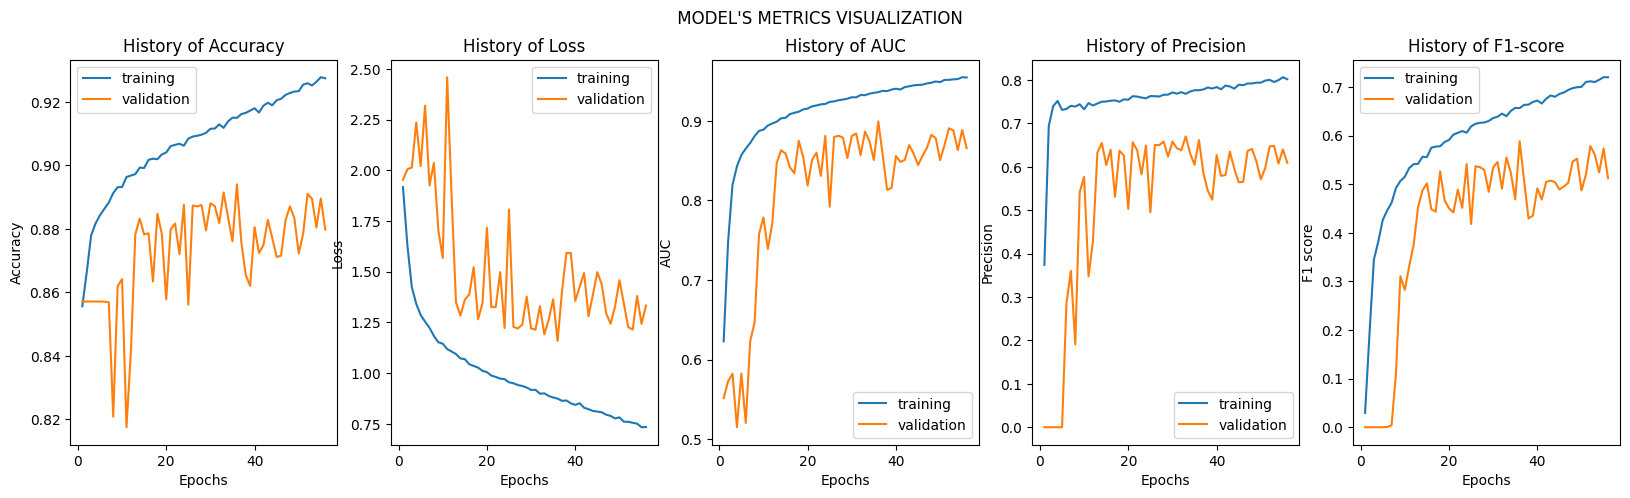

In [79]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [99]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val
model = tf.keras.models.load_model("/Users/sakshamjain/Desktop/invictus/tempres.h5", custom_objects={'f1_score': f1_score})

In [100]:
model.evaluate(test_dataset)


29/29 [==============================] - 9s 230ms/step - loss: 1.2786 - accuracy: 0.8836 - precision: 0.6204 - recall: 0.4777 - auc: 0.8785 - f1_score: 0.5417


[1.2786240577697754,
 0.8836325407028198,
 0.6204088926315308,
 0.47770968079566956,
 0.8784981966018677,
 0.5417167544364929]

In [95]:
train_dataset.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}